# ***UIC IDS 561 Project***


> ##### ***Prathamesh Bapat - Lina Quiceno - Joshua Pollack***





[Project Proposal Link](https://drive.google.com/file/d/1_JhWuOM1gRoqVTAcZgLiUzYKrztitH53/view?usp=sharing)

### **Spark Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# To create the enviornment
%cd /content/drive/My Drive/IDS_561_Project/
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/IDS_561_Project/spark-3.1.2-bin-hadoop3.2"

!chmod 755 -R "/content/drive/My Drive/IDS_561_Project/"

/content/drive/.shortcut-targets-by-id/1Wx63VWmRb35eaY0ovvA2dB_G_7zTEYSj/IDS_561_Project


### **Spark Session**
Creat a local Spark session

In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

### **Loading and Cleaning the DATASET**

In [4]:
# Read the data.
df = spark.read.csv("data.txt", header=True)

In [5]:
df.show(n=20)

+------+----+---------+---------+------+--------+------+-------+--------+--------+--------+------+-------+---------+-------+------+-------+--------+--------+--------+--------+--------+--------+--------+--------+---------+-------+------+--------+--------+---------+------+---------+---------+---------+------+---------+---------+----+--------+------+---------+---------+-------+-------+---------+-------+-------+---------+---------+-----+---------+--------+---------+-------+-------+----+--------+--------+---------+---------+--------+-------+-------+--------+-----+--------+--------+--------+
|caseid|dAge|dAncstry1|dAncstry2|iAvail|iCitizen|iClass|dDepart|iDisabl1|iDisabl2|iEnglish|iFeb55|iFertil|dHispanic|dHour89|dHours|iImmigr|dIncome1|dIncome2|dIncome3|dIncome4|dIncome5|dIncome6|dIncome7|dIncome8|dIndustry|iKorean|iLang1|iLooking|iMarital|iMay75880|iMeans|iMilitary|iMobility|iMobillim|dOccup|iOthrserv|iPerscare|dPOB|dPoverty|dPwgt1|iRagechld|dRearning|iRelat1|iRelat2|iRemplpar|iRiders|iRla

In [6]:
# Change all feature types from String to Integer.
from pyspark.sql.types import IntegerType
for name in range(len(df.schema.names)):
         df = df.withColumn(df.schema.names[name], df[df.schema.names[name]].cast(IntegerType()))
df.printSchema()

root
 |-- caseid: integer (nullable = true)
 |-- dAge: integer (nullable = true)
 |-- dAncstry1: integer (nullable = true)
 |-- dAncstry2: integer (nullable = true)
 |-- iAvail: integer (nullable = true)
 |-- iCitizen: integer (nullable = true)
 |-- iClass: integer (nullable = true)
 |-- dDepart: integer (nullable = true)
 |-- iDisabl1: integer (nullable = true)
 |-- iDisabl2: integer (nullable = true)
 |-- iEnglish: integer (nullable = true)
 |-- iFeb55: integer (nullable = true)
 |-- iFertil: integer (nullable = true)
 |-- dHispanic: integer (nullable = true)
 |-- dHour89: integer (nullable = true)
 |-- dHours: integer (nullable = true)
 |-- iImmigr: integer (nullable = true)
 |-- dIncome1: integer (nullable = true)
 |-- dIncome2: integer (nullable = true)
 |-- dIncome3: integer (nullable = true)
 |-- dIncome4: integer (nullable = true)
 |-- dIncome5: integer (nullable = true)
 |-- dIncome6: integer (nullable = true)
 |-- dIncome7: integer (nullable = true)
 |-- dIncome8: integer (nu

In [7]:
# To find all the distinct label values.
df.select('dIncome1').distinct().collect()

[Row(dIncome1=1),
 Row(dIncome1=3),
 Row(dIncome1=4),
 Row(dIncome1=2),
 Row(dIncome1=0)]

In [8]:
label = df.select('dIncome1').collect()

In [9]:
# Check distribution of the Label
sum = 0
for i in range(len(label)):
  if int(label[i][0]) <= 3:
    sum = sum + 1
print('Label with income less than 60k =', sum/len(label))    
print('Label with income greater than or equal to 60k =', 1 - (sum/len(label)))    
   

Label with income less than 60k = 0.9806068051507454
Label with income greater than or equal to 60k = 0.019393194849254614


***`BASE LINE ACCURACY -> 0.96`***

In [10]:
# Convert exisitng label values [0,1,2,3,4] --> 0 for Income less than 60k(Label<=3) else ---> 1. (To make it a classifictaion problem)
from pyspark.sql import functions as F
df = df.withColumn('dIncome1',
    F.when(df['dIncome1']<=3, 0).
    when(df['dIncome1']>3, 1).
    otherwise(df['dIncome1']))

df.select('dIncome1').distinct().collect()

[Row(dIncome1=1), Row(dIncome1=0)]

In [11]:
df = df.drop(*('dDepart', 'iMeans', 'iMobility', 'iMobillim', 'dPoverty', 'iRiders', 'caseid'))

In [12]:
df.take(5)

[Row(dAge=5, dAncstry1=0, dAncstry2=1, iAvail=0, iCitizen=0, iClass=5, iDisabl1=2, iDisabl2=2, iEnglish=1, iFeb55=0, iFertil=1, dHispanic=0, dHour89=4, dHours=3, iImmigr=0, dIncome1=0, dIncome2=0, dIncome3=0, dIncome4=1, dIncome5=0, dIncome6=0, dIncome7=0, dIncome8=0, dIndustry=10, iKorean=0, iLang1=1, iLooking=0, iMarital=1, iMay75880=0, iMilitary=4, dOccup=3, iOthrserv=0, iPerscare=2, dPOB=0, dPwgt1=1, iRagechld=4, dRearning=3, iRelat1=0, iRelat2=0, iRemplpar=0, iRlabor=1, iRownchld=0, dRpincome=3, iRPOB=22, iRrelchld=0, iRspouse=3, iRvetserv=0, iSchool=1, iSept80=0, iSex=1, iSubfam1=0, iSubfam2=0, iTmpabsnt=0, dTravtime=5, iVietnam=0, dWeek89=2, iWork89=1, iWorklwk=1, iWWII=0, iYearsch=11, iYearwrk=1, dYrsserv=0),
 Row(dAge=6, dAncstry1=1, dAncstry2=1, iAvail=0, iCitizen=0, iClass=7, iDisabl1=2, iDisabl2=2, iEnglish=0, iFeb55=0, iFertil=3, dHispanic=0, dHour89=1, dHours=1, iImmigr=0, dIncome1=0, dIncome2=0, dIncome3=0, dIncome4=0, dIncome5=0, dIncome6=1, dIncome7=0, dIncome8=0, dInd

In [13]:
df = df.withColumnRenamed('dIncome1','label')

## ***EDA***

In [33]:
import pandas as pd
pandas_df = pd.read_csv('data.txt')
del pandas_df['caseid']

##### ***Label Distribution***

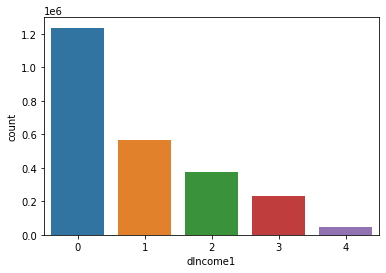

In [34]:
import seaborn as sns
from matplotlib import  pyplot as plt
sns.countplot(data = pandas_df, x = 'dIncome1')
plt.show()

#### ***Each feature distribution***

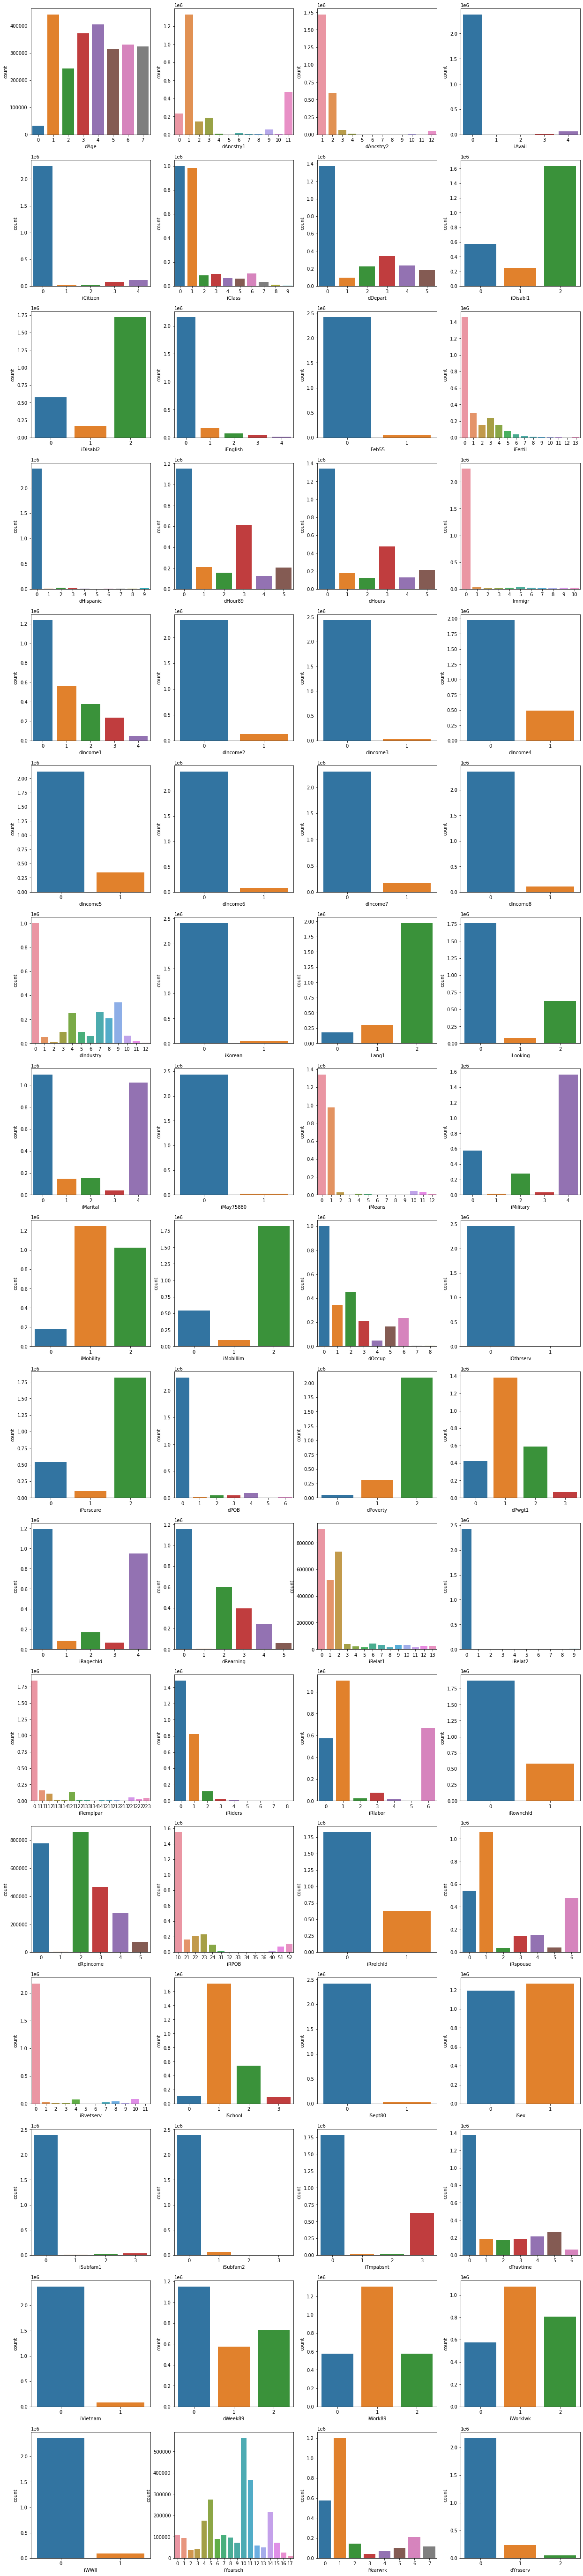

In [35]:
fig, axs = plt.subplots(17, 4, figsize = (21, 100)) 
axs = axs.flatten()
x = 0
for feature in pandas_df.columns:
    sns.countplot(data = pandas_df, x = feature , ax = axs[x])
    x = x+1

#### ***Feature-Label Relationship***

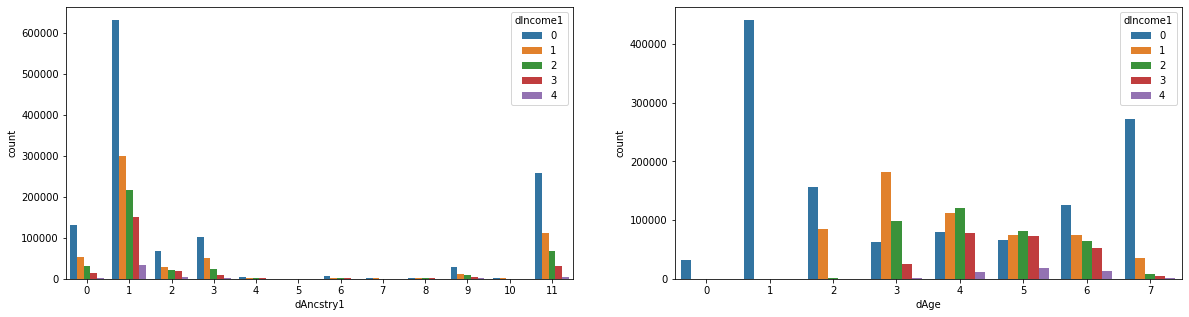

In [36]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

sns.countplot(data = pandas_df, x ='dAncstry1', hue = 'dIncome1', ax=axs[0])
sns.countplot(data = pandas_df, x ='dAge', hue = 'dIncome1', ax = axs[1])
plt.show()

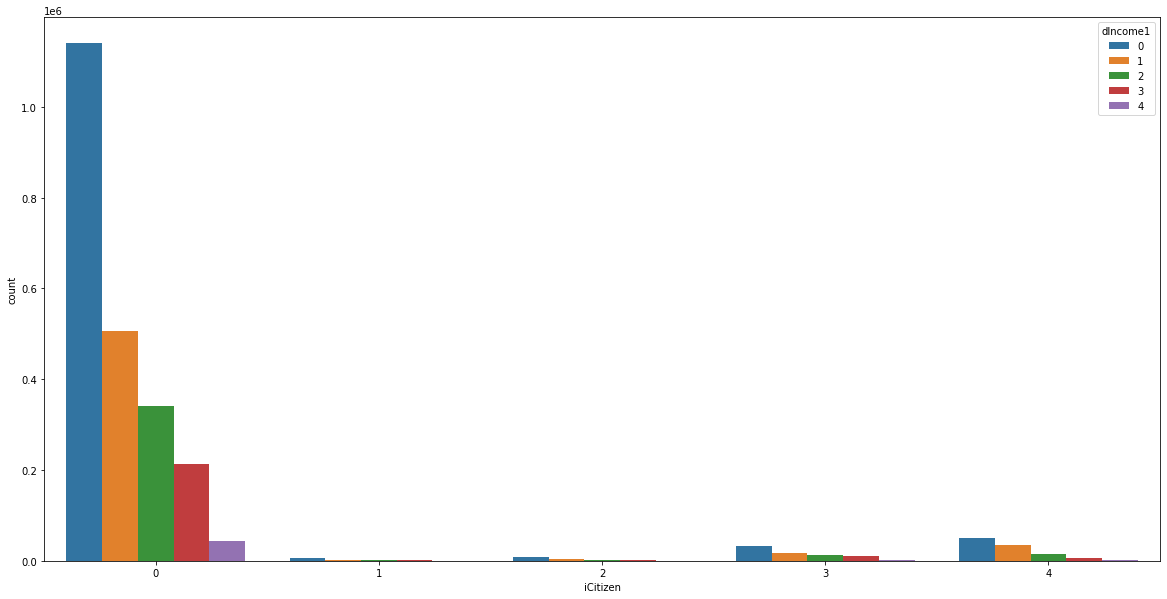

In [37]:
fig, axs = plt.subplots(1, 1, figsize = (20, 10))

sns.countplot(data = pandas_df, x ='iCitizen', hue = 'dIncome1', ax=axs)
plt.show()

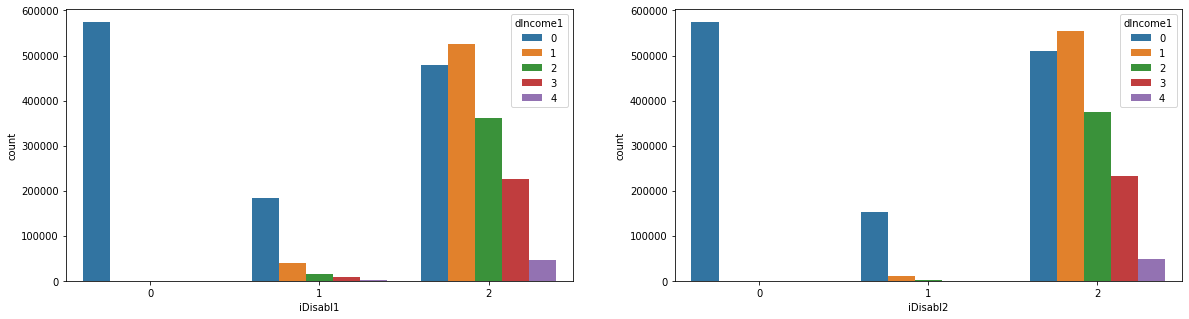

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

sns.countplot(data = pandas_df, x ='iDisabl1', hue = 'dIncome1', ax=axs[0])
sns.countplot(data = pandas_df, x ='iDisabl2', hue = 'dIncome1', ax=axs[1])
plt.show()

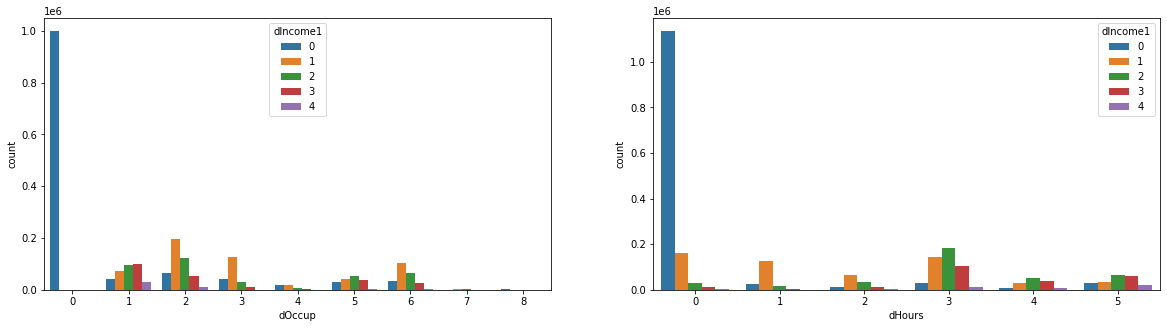

In [39]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

sns.countplot(data = pandas_df, x ='dOccup', hue = 'dIncome1', ax=axs[0])
sns.countplot(data = pandas_df, x ='dHours', hue = 'dIncome1', ax = axs[1])
plt.show()

## ***MODELS***

#### ***Create feature column with label***

In [21]:
cols=df.columns
cols.remove('label')
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol='features')
# Now let us use the transform method to transform our dataset
data=assembler.transform(df)

In [22]:
data.select("features").show(truncate=False, n=5)
data.select("label").show(truncate=False, n=5)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(61,[0,2,5,6,7,8,10,12,13,17,22,24,26,28,29,31,33,34,35,39,41,42,44,46,48,52,54,55,56,58,59],[5.0,1.0,5.0,2.0,2.0,1.0,1.0,4.0,3.0,1.0,10.0,1.0,1.0,4.0,3.0,2.0,1.0,4.0,3.0,1.0,3.0,22.0,3.0,1.0,1.0,5.0,2.0,1.0,1.0,11.0,1.0])      |
|(61,[0,1,2,5,6,7,10,12,13,19,22,24,28,29,31,33,34,35,36,39,41,42,44,46,48,5

### ***Logistic Regression***

In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import time

train, test = data.randomSplit([0.8, 0.2], seed=12345)
lr = LogisticRegression(labelCol = 'label', featuresCol= 'features', maxIter=5, regParam=0.01, aggregationDepth=5, fitIntercept=True)
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

start_time = time.time()
bestModel = lr.fit(train)
end_time = time.time()

training_time = end_time - start_time

print("The time taken to train the data is: %0.3f seconds" %training_time)

#bestModel = lrModel.bestModel
lr_predictions = bestModel.transform(test)

LR_roc = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderROC"})
LR_pr = evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(LR_roc))
print("Area under PR Curve: {:.4f}".format(LR_pr))

The time taken to train the data is: 178.401 seconds
Area under ROC Curve: 0.9797
Area under PR Curve: 0.6498


### ***Naive Bayes***

In [26]:
from pyspark.ml.classification import NaiveBayes
import time

train, test = data.randomSplit([0.8, 0.2], seed=12345)
lr = NaiveBayes(smoothing=1.0, labelCol = 'label', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

start_time = time.time()
bestModel = lr.fit(train)
end_time = time.time()

training_time = end_time - start_time

print("The time taken to train the data is: %0.3f seconds" %training_time)

#bestModel = lrModel.bestModel
nb_predictions = bestModel.transform(test)

NB_roc = evaluator.evaluate(nb_predictions, {evaluator.metricName: "areaUnderROC"})
NB_pr = evaluator.evaluate(nb_predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(NB_roc))
print("Area under PR Curve: {:.4f}".format(NB_pr))

The time taken to train the data is: 94.444 seconds
Area under ROC Curve: 0.6620
Area under PR Curve: 0.0271


### ***Support Vector Machine***

In [27]:
from pyspark.ml.classification import LinearSVC
import time

train, test = data.randomSplit([0.8, 0.2], seed=12345)
lr = LinearSVC(maxIter=10, regParam=0.1, labelCol = 'label', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

start_time = time.time()
bestModel = lr.fit(train)
end_time = time.time()

training_time = end_time - start_time

print("The time taken to train the data is: %0.3f seconds" %training_time)

#bestModel = lrModel.bestModel
svm_predictions = bestModel.transform(test)

SVM_roc = evaluator.evaluate(svm_predictions, {evaluator.metricName: "areaUnderROC"})
SVM_pr = evaluator.evaluate(svm_predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(SVM_roc))
print("Area under PR Curve: {:.4f}".format(SVM_pr))

The time taken to train the data is: 205.889 seconds
Area under ROC Curve: 0.9042
Area under PR Curve: 0.1557


### ***Decision Tree***

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier
import time

train, test = data.randomSplit([0.8, 0.2], seed=12345)
lr = DecisionTreeClassifier(labelCol = 'label', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

start_time = time.time()
bestModel = lr.fit(train)
end_time = time.time()

training_time = end_time - start_time

print("The time taken to train the data is: %0.3f seconds" %training_time)

#bestModel = lrModel.bestModel
dt_predictions = bestModel.transform(test)

DT_roc = evaluator.evaluate(dt_predictions, {evaluator.metricName: "areaUnderROC"})
DT_pr = evaluator.evaluate(dt_predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(DT_roc))
print("Area under PR Curve: {:.4f}".format(DT_pr))

The time taken to train the data is: 330.935 seconds
Area under ROC Curve: 0.9967
Area under PR Curve: 0.9880


### ***Random Forest***

In [29]:
from pyspark.ml.classification import RandomForestClassifier
import time

train, test = data.randomSplit([0.8, 0.2], seed=12345)
lr = RandomForestClassifier(numTrees = 10, featureSubsetStrategy='auto', impurity='gini', maxDepth=4, maxBins=32, seed=50, labelCol = 'label', featuresCol= 'features')
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator

start_time = time.time()
bestModel = lr.fit(train)
end_time = time.time()

training_time = end_time - start_time

print("The time taken to train the data is: %0.3f seconds" %training_time)

#bestModel = lrModel.bestModel
rf_predictions = bestModel.transform(test)

RF_roc = evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderROC"})
RF_pr = evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(RF_roc))
print("Area under PR Curve: {:.4f}".format(RF_pr))

The time taken to train the data is: 331.456 seconds
Area under ROC Curve: 0.9994
Area under PR Curve: 0.9834


### ***FINAL TABLE***

In [32]:
from beautifultable import BeautifulTable
table = BeautifulTable()
table.rows.append(['Logistic Regression', LR_roc, LR_pr])
table.rows.append(['Decision Tree', DT_roc, DT_pr])
table.rows.append(['Support Vectot Machines', SVM_roc, SVM_pr])
table.rows.append(['Naive Bayes', NB_roc, NB_pr])
table.rows.append(['Random Forest', RF_roc, RF_pr])
table.columns.header = ['MODEL', 'ROC AUC', 'PR AUC' ]
print(table)

+-------------------------+---------+--------+
|          MODEL          | ROC AUC | PR AUC |
+-------------------------+---------+--------+
|   Logistic Regression   |  0.98   |  0.65  |
+-------------------------+---------+--------+
|      Decision Tree      |  0.997  | 0.988  |
+-------------------------+---------+--------+
| Support Vectot Machines |  0.904  | 0.156  |
+-------------------------+---------+--------+
|       Naive Bayes       |  0.662  | 0.027  |
+-------------------------+---------+--------+
|      Random Forest      |  0.999  | 0.983  |
+-------------------------+---------+--------+
